<a href="https://colab.research.google.com/github/unicorn-yh/Story-Generation-NLP/blob/main/story_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story Generation using LSTM Model

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils
import requests
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/MyDrive/story_generation_dataset/'

Mounted at /content/gdrive


In [3]:
train_stories = pd.read_csv(data_path+"ROCStories_train.csv", encoding="utf8")
test_stories = pd.read_csv(data_path+"ROCStories_test.csv", encoding="utf8")
val_stories = pd.read_csv(data_path+"ROCStories_val.csv", encoding="utf8")

In [4]:
train_stories = train_stories.append(val_stories)
train_stories.head()

,storyid,storytitle,sentence1,sentence2,sentence3,sentence4,sentence5
0,8bbe6d11-1e2e-413c-bf81-eaea05f4f1bd,David Drops the Weight,David noticed he had put on a lot of weight re...,He examined his habits to try and figure out t...,He realized he'd been eating too much fast foo...,He stopped going to burger places and started ...,"After a few weeks, he started to feel much bet..."
1,0beabab2-fb49-460e-a6e6-f35a202e3348,Frustration,Tom had a very short temper.,One day a guest made him very angry.,He punched a hole in the wall of his house.,Tom's guest became afraid and left quickly.,Tom sat on his couch filled with regret about ...
2,87da1a22-df0b-410c-b186-439700b70ba6,Marcus Buys Khakis,Marcus needed clothing for a business casual e...,All of his clothes were either too formal or t...,He decided to buy a pair of khakis.,The pair he bought fit him perfectly.,Marcus was happy to have the right clothes for...
3,2d16bcd6-692a-4fc0-8e7c-4a6f81d9efa9,Different Opinions,Bobby thought Bill should buy a trailer and ha...,Bill thought a truck would be better for what ...,Bobby pointed out two vehicles were much more ...,Bill was set in his ways with conventional thi...,He ended up buying the truck he wanted despite...
4,c71bb23b-7731-4233-8298-76ba6886cee1,Overcoming shortcomings,John was a pastor with a very bad memory.,He tried to memorize his sermons many days in ...,He decided to learn to sing to overcome his ha...,He then made all his sermons into music and sa...,His congregation was delighted and so was he.


In [5]:
test_stories.head()

,storyid,storytitle,sentence1,sentence2,sentence3,sentence4,sentence5
0,a34dd5ad-761f-4369-acaf-42e146479c9b,Bad Dream,Tommy was very close to his dad and loved him ...,His was a cop and was shot and killed on duty.,Tommy cried in his mother's arms at the funeral.,Tommy suddenly woke up in a cold sweat.,"Realizing he had just had a bad dream, he went..."
1,d14fc434-01da-4b39-9e7b-3733c510ac29,Scary Movies,Tim was dating a girl who was easily scared.,He decided to have a horror movie night.,She reluctantly agreed.,Tim's girlfriend was scared and stayed close t...,Tim's plan worked perfectly.
2,56800cdf-d149-489f-9ee4-a87ea3138533,Red Butterfly,Samuel collected butterflies for his collection.,One afternoon he spotted a bright red butterfly.,He tried to catch it but it kept flying higher.,Samuel got a ladder and went to the roof of hi...,He missed his footing and went tumbling off th...
3,0ba922c2-afe4-444f-a9b7-8bcf202ebf65,Dirty Feet,She ran outside without her shoes.,She was excited to catch the ice cream man.,She ordered her ice cream and ran home.,She ran into the house.,Her mother yelled because her feet were dirty.
4,f81f29cd-b6f4-4faf-af9a-b779787a6b34,Bullfrog,There once was a man named Larry Butterfrog.,He went down to buy World of Warcraft.,"However, he lacked the money.","So, he had to go to his mom, who was miffed.",And she told him to get a job.


In [6]:
train_stories = train_stories[:1000]
test_stories = test_stories[:250]

In [7]:
print('Train Dataset')
print(train_stories.values.shape)
train_array = train_stories.values[:,1:].reshape(-1).tolist()
print(len(train_array))
train_array[:10]

Train Dataset
(1000, 7)
6000


['David Drops the Weight',
 'David noticed he had put on a lot of weight recently.',
 'He examined his habits to try and figure out the reason.',
 "He realized he'd been eating too much fast food lately.",
 'He stopped going to burger places and started a vegetarian diet.',
 'After a few weeks, he started to feel much better.',
 'Frustration',
 'Tom had a very short temper.',
 'One day a guest made him very angry.',
 'He punched a hole in the wall of his house.']

In [8]:
print('Test Dataset')
print(test_stories.values.shape)
test_array = test_stories.values[:,1:].reshape(-1).tolist()
print(len(test_array))

Test Dataset
(250, 7)
1500


In [9]:
def tokenize(sent):
      tokenized_sent = []
      sent = re.split(r'[`\=~!@#^&*()_+\[\]{};\\:"|<,./<>?]|\n| ', sent)
      for w in sent:
            w.lower().replace('.','')
            tokenized_sent.append(w)
      return tokenized_sent

In [10]:
# Tokenization of each document
def tokenize_doc(doc):
    tokenized_doc = []
    for sent in train_array:
        tokenized_doc.append(tokenize(sent))
    return tokenized_doc


In [11]:
train_tokenized_doc = tokenize_doc(train_array)
test_tokenized_doc = tokenize_doc(test_array)
print(train_tokenized_doc[:10])

[['David', 'Drops', 'the', 'Weight'], ['David', 'noticed', 'he', 'had', 'put', 'on', 'a', 'lot', 'of', 'weight', 'recently', ''], ['He', 'examined', 'his', 'habits', 'to', 'try', 'and', 'figure', 'out', 'the', 'reason', ''], ['He', 'realized', "he'd", 'been', 'eating', 'too', 'much', 'fast', 'food', 'lately', ''], ['He', 'stopped', 'going', 'to', 'burger', 'places', 'and', 'started', 'a', 'vegetarian', 'diet', ''], ['After', 'a', 'few', 'weeks', '', 'he', 'started', 'to', 'feel', 'much', 'better', ''], ['Frustration'], ['Tom', 'had', 'a', 'very', 'short', 'temper', ''], ['One', 'day', 'a', 'guest', 'made', 'him', 'very', 'angry', ''], ['He', 'punched', 'a', 'hole', 'in', 'the', 'wall', 'of', 'his', 'house', '']]


In [12]:
# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(train_tokenized_doc)]
tagged_data[:10]

[TaggedDocument(words=['David', 'Drops', 'the', 'Weight'], tags=[0]),
 TaggedDocument(words=['David', 'noticed', 'he', 'had', 'put', 'on', 'a', 'lot', 'of', 'weight', 'recently', ''], tags=[1]),
 TaggedDocument(words=['He', 'examined', 'his', 'habits', 'to', 'try', 'and', 'figure', 'out', 'the', 'reason', ''], tags=[2]),
 TaggedDocument(words=['He', 'realized', "he'd", 'been', 'eating', 'too', 'much', 'fast', 'food', 'lately', ''], tags=[3]),
 TaggedDocument(words=['He', 'stopped', 'going', 'to', 'burger', 'places', 'and', 'started', 'a', 'vegetarian', 'diet', ''], tags=[4]),
 TaggedDocument(words=['After', 'a', 'few', 'weeks', '', 'he', 'started', 'to', 'feel', 'much', 'better', ''], tags=[5]),
 TaggedDocument(words=['Frustration'], tags=[6]),
 TaggedDocument(words=['Tom', 'had', 'a', 'very', 'short', 'temper', ''], tags=[7]),
 TaggedDocument(words=['One', 'day', 'a', 'guest', 'made', 'him', 'very', 'angry', ''], tags=[8]),
 TaggedDocument(words=['He', 'punched', 'a', 'hole', 'in', 't

In [13]:
## Train doc2vec model
import os
if not os.path.exists(data_path+"output/train_doc2vec.model"):
    model = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4, epochs = 100)
    # Save trained doc2vec model
    model.save(data_path+"output/train_doc2vec.model")
else:
    ## Load saved doc2vec model
    model= Doc2Vec.load(data_path+"output/train_doc2vec.model")

In [14]:
matrix_shape = int(len(train_array)/6)

In [15]:
# find most similar doc 
def find_similar_doc(doc):
      train_doc = tokenize(doc)
      sim = model.docvecs.most_similar(positive=[model.infer_vector(train_doc)],topn=matrix_shape)
      return sim
      
def createList(r1, r2):
    return [item for item in range(r1, r2+1)]

In [16]:
d = find_similar_doc("I owns a cat.")
len(d)
d

[(2781, 0.769499659538269),
 (3856, 0.7685728073120117),
 (4776, 0.7606507539749146),
 (2486, 0.7589677572250366),
 (993, 0.7339786887168884),
 (2871, 0.7335665225982666),
 (5198, 0.7335535287857056),
 (4649, 0.724053680896759),
 (1450, 0.7221837043762207),
 (1799, 0.7169935703277588),
 (1765, 0.7037559747695923),
 (4200, 0.6998993158340454),
 (5679, 0.6995673179626465),
 (5501, 0.6943663358688354),
 (2283, 0.6909667253494263),
 (1888, 0.6878414750099182),
 (241, 0.6850816011428833),
 (2598, 0.6821537017822266),
 (4088, 0.6801121234893799),
 (2566, 0.679614782333374),
 (5319, 0.6714149713516235),
 (5564, 0.6701730489730835),
 (3673, 0.6669113636016846),
 (931, 0.6668003797531128),
 (3996, 0.6636756062507629),
 (3854, 0.6586158275604248),
 (5760, 0.6563472747802734),
 (491, 0.6558236479759216),
 (2546, 0.6511505842208862),
 (841, 0.6455106139183044),
 (4999, 0.645501971244812),
 (992, 0.6404850482940674),
 (4293, 0.6387183666229248),
 (254, 0.6375248432159424),
 (5558, 0.636712551116943

In [17]:
for prob in d:
      print(prob[1])

0.769499659538269
0.7685728073120117
0.7606507539749146
0.7589677572250366
0.7339786887168884
0.7335665225982666
0.7335535287857056
0.724053680896759
0.7221837043762207
0.7169935703277588
0.7037559747695923
0.6998993158340454
0.6995673179626465
0.6943663358688354
0.6909667253494263
0.6878414750099182
0.6850816011428833
0.6821537017822266
0.6801121234893799
0.679614782333374
0.6714149713516235
0.6701730489730835
0.6669113636016846
0.6668003797531128
0.6636756062507629
0.6586158275604248
0.6563472747802734
0.6558236479759216
0.6511505842208862
0.6455106139183044
0.645501971244812
0.6404850482940674
0.6387183666229248
0.6375248432159424
0.6367125511169434
0.6366021633148193
0.6361395120620728
0.6334017515182495
0.6294677257537842
0.6290642023086548
0.6289631128311157
0.6273675560951233
0.6246641874313354
0.6230474710464478
0.6218588352203369
0.6217656135559082
0.6200273633003235
0.6187365651130676
0.6174434423446655
0.6163179278373718
0.6157107353210449
0.6127581596374512
0.61094266176223

In [18]:
print('a')

a


In [19]:
similar_matrix = []
index_ls = []
X,Y=[],[]
with open(data_path+"output/similar_matrix_"+ str(matrix_shape) +".txt","w") as sfile:
      for i in range(0,len(train_array),6):  #1000
            prob_ls = ""
            tmp_index_ls = []
            tmp_index_ls = createList(i,i+5)
            index_ls.append(tmp_index_ls)
            sim_output = ""
            sim_output += train_array[i] + ","
            sim = find_similar_doc(sim_output)
            sim_index = 0
            for tup in sim:
                  if sim_index == 0:
                    Y.append(tup[0])
                    sim_index += 1
                  prob_ls += str(round(tup[1],4)) + " "  #1000
            #similar_matrix.append(prob_ls)
            if not i+6 >= len(train_array)-1:
                  print(i,"/",len(train_array))
            else:
                  print(i,"/",len(train_array),end="\r")
            sfile.write(prob_ls)
sfile.close()
X = index_ls
X = np.array(X)
Y = np.array(Y)
print(X.shape,Y.shape)
print(X[:5],Y[:5])




0 / 6000
6 / 6000
12 / 6000
18 / 6000
24 / 6000
30 / 6000
36 / 6000
42 / 6000
48 / 6000
54 / 6000
60 / 6000
66 / 6000
72 / 6000
78 / 6000
84 / 6000
90 / 6000
96 / 6000
102 / 6000
108 / 6000
114 / 6000
120 / 6000
126 / 6000
132 / 6000
138 / 6000
144 / 6000
150 / 6000
156 / 6000
162 / 6000
168 / 6000
174 / 6000
180 / 6000
186 / 6000
192 / 6000
198 / 6000
204 / 6000
210 / 6000
216 / 6000
222 / 6000
228 / 6000
234 / 6000
240 / 6000
246 / 6000
252 / 6000
258 / 6000
264 / 6000
270 / 6000
276 / 6000
282 / 6000
288 / 6000
294 / 6000
300 / 6000
306 / 6000
312 / 6000
318 / 6000
324 / 6000
330 / 6000
336 / 6000
342 / 6000
348 / 6000
354 / 6000
360 / 6000
366 / 6000
372 / 6000
378 / 6000
384 / 6000
390 / 6000
396 / 6000
402 / 6000
408 / 6000
414 / 6000
420 / 6000
426 / 6000
432 / 6000
438 / 6000
444 / 6000
450 / 6000
456 / 6000
462 / 6000
468 / 6000
474 / 6000
480 / 6000
486 / 6000
492 / 6000
498 / 6000
504 / 6000
510 / 6000
516 / 6000
522 / 6000
528 / 6000
534 / 6000
540 / 6000
546 / 6000
552 / 6

In [20]:
with open(data_path+"output/X_train.txt","w") as xfile:
    for row in X:
      for i in row:
        xfile.write(str(i)+" ")
with open(data_path+"output/Y_train.txt","w") as yfile:
    for i in Y:
        yfile.write(str(i)+" ")
xfile.close()
yfile.close()

In [21]:
X_train = np.loadtxt(data_path+"output/X_train.txt")
Y_train = np.loadtxt(data_path+"output/Y_train.txt")
X_train.shape, Y_train.shape
X_train = X_train.reshape(Y_train.shape[0],-1)
print(X_train.shape, Y_train.shape)

(1000, 6) (1000,)


In [22]:
index_ls = []
X_test,Y_test=[],[]
for i in range(0,len(test_array),6):  #1000
      tmp_index_ls = []
      tmp_index_ls = createList(i,i+5)
      index_ls.append(tmp_index_ls)
      sim_output = ""
      sim_output += test_array[i] + ","
      sim = find_similar_doc(sim_output)
      sim_index = 0
      for tup in sim:
            if sim_index == 0:
                Y_test.append(tup[0])
                sim_index += 1
      if not i+6 >= len(test_array)-1:
            print(i,"/",len(test_array))
      else:
            print(i,"/",len(test_array),end="\r")
X_test = index_ls
X_test = np.array(X_test)
Y_test = np.array(Y_test)
print(X_test.shape,Y_test.shape)
print(X_test[:5],Y_test[:5])

0 / 1500
6 / 1500
12 / 1500
18 / 1500
24 / 1500
30 / 1500
36 / 1500
42 / 1500
48 / 1500
54 / 1500
60 / 1500
66 / 1500
72 / 1500
78 / 1500
84 / 1500
90 / 1500
96 / 1500
102 / 1500
108 / 1500
114 / 1500
120 / 1500
126 / 1500
132 / 1500
138 / 1500
144 / 1500
150 / 1500
156 / 1500
162 / 1500
168 / 1500
174 / 1500
180 / 1500
186 / 1500
192 / 1500
198 / 1500
204 / 1500
210 / 1500
216 / 1500
222 / 1500
228 / 1500
234 / 1500
240 / 1500
246 / 1500
252 / 1500
258 / 1500
264 / 1500
270 / 1500
276 / 1500
282 / 1500
288 / 1500
294 / 1500
300 / 1500
306 / 1500
312 / 1500
318 / 1500
324 / 1500
330 / 1500
336 / 1500
342 / 1500
348 / 1500
354 / 1500
360 / 1500
366 / 1500
372 / 1500
378 / 1500
384 / 1500
390 / 1500
396 / 1500
402 / 1500
408 / 1500
414 / 1500
420 / 1500
426 / 1500
432 / 1500
438 / 1500
444 / 1500
450 / 1500
456 / 1500
462 / 1500
468 / 1500
474 / 1500
480 / 1500
486 / 1500
492 / 1500
498 / 1500
504 / 1500
510 / 1500
516 / 1500
522 / 1500
528 / 1500
534 / 1500
540 / 1500
546 / 1500
552 / 1

In [23]:
with open(data_path+"output/X_test.txt","w") as xfile:
    for row in X_test:
      for i in row:
        xfile.write(str(i)+" ")
with open(data_path+"output/Y_test.txt","w") as yfile:
    for i in Y_test:
        yfile.write(str(i)+" ")
xfile.close()
yfile.close()

In [24]:
X_test = np.loadtxt(data_path+"output/X_test.txt")
Y_test = np.loadtxt(data_path+"output/Y_test.txt")
print(X_test.shape, Y_test.shape)
X_test = X_test.reshape(Y_test.shape[0],-1)
print(X_test.shape, Y_test.shape)

(1500,) (250,)
(250, 6) (250,)


In [25]:
matrix_shape = len(Y_train)
sim_matrix = np.loadtxt(data_path+"output/similar_matrix_1000.txt")
sim_matrix.shape
emb_matrix = sim_matrix.reshape(matrix_shape,-1)
emb_matrix.shape

(1000, 1000)

In [26]:
emb_matrix[0]

array([0.9658, 0.8618, 0.8378, 0.8087, 0.7951, 0.7892, 0.7763, 0.7726,
       0.7691, 0.7686, 0.7672, 0.7658, 0.7648, 0.7599, 0.7596, 0.7581,
       0.7553, 0.7481, 0.7467, 0.7457, 0.7455, 0.7416, 0.7411, 0.7411,
       0.7375, 0.7371, 0.7368, 0.736 , 0.7351, 0.7341, 0.7333, 0.7315,
       0.7284, 0.7271, 0.7261, 0.7256, 0.725 , 0.7248, 0.7247, 0.7247,
       0.7219, 0.7199, 0.7195, 0.7195, 0.7195, 0.7176, 0.7165, 0.7153,
       0.7131, 0.713 , 0.7125, 0.7115, 0.7094, 0.7077, 0.7058, 0.7049,
       0.7047, 0.7045, 0.7039, 0.7031, 0.701 , 0.6996, 0.6984, 0.6973,
       0.6971, 0.697 , 0.6945, 0.6945, 0.6944, 0.6944, 0.6944, 0.6938,
       0.6935, 0.6928, 0.6927, 0.6918, 0.6909, 0.6882, 0.6869, 0.6854,
       0.6852, 0.6847, 0.6844, 0.6839, 0.6837, 0.6835, 0.683 , 0.6825,
       0.6823, 0.6818, 0.6812, 0.6811, 0.6803, 0.6796, 0.6794, 0.6789,
       0.6782, 0.6781, 0.6775, 0.6765, 0.6764, 0.6764, 0.6756, 0.6756,
       0.6756, 0.6746, 0.6735, 0.6729, 0.6722, 0.672 , 0.6717, 0.6703,
      

In [27]:
class GRU_model(nn.Module):
    def __init__(self):
        super(GRU, self).__init__()
        self.V = matrix_shape    #vocab_size=1000
        self.D = matrix_shape    #n_input=1000
        self.C = matrix_shape          #n_classes=1000
        self.layers = 2
        self.drop = 0.2
        weight_matrix = torch.from_numpy(emb_matrix)
        self.bidirectional =  False
        self.num_directions = 1
        self.hidden_size = 2400
        self.batch_size = 64
        self.embed = nn.Embedding(self.V, self.D)
        self.embed.weight.data.copy_(weight_matrix)
        self.embed.weight.requires_grad = False
        self.alpha = 5e-3
        self.min_alpha = 1e-5

        self.rnn = nn.GRU(               
            input_size=self.D,                #The number of expected features in the input x 
            hidden_size=self.hidden_size,     # rnn hidden unit
            num_layers=self.layers,           # number of rnn layers
            batch_first=True,                 # set batch first
            dropout=self.drop,                #dropout probability
            bidirectional=self.bidirectional  #bi-GRU
        )

        self.fc = nn.Linear(self.num_directions*self.hidden_size, self.C)

    def forward(self, x):
        # x shape (batch, time_step, input_size), time_step--->seq_len
        # r_out shape (batch, time_step, output_size), out_put_size--->num_directions*hidden_size
        # h_0 shape (num_layers*num_directions, batch, hidden_size), here we use zero initialization
        # h_n shape (num_layers*num_directions, batch, hidden_size)
        x = self.embed(x)  # (N, W, D)
        
        #initialization hidden state
        #1.zero init
        r_out, h_n = self.rnn(x, None)  # None represents zero initial hidden state
        
        # choose r_out at the last time step or outputs at every time step
        if self.bidirectional:
            #concatenate normal RNN's last time step(-1) output and reverse RNN's last time step(0) output
            #print(r_out[:, -1, :self.hidden_size].size()) #[B, hidden_size]
            out = torch.cat([r_out[:, -1, :self.hidden_size],r_out[:, 0, self.hidden_size:]],1)
        else:
            out = r_out[:, -1, :] #[B, hidden_size*num_directions]
        
        out = self.fc(self.dropout(out))
        
        return out

In [28]:
class BiLSTM_model(nn.Module):
    def __init__(self, vocab_size=1000, ninp=1000, ntoken=150,  nhid=150, nlayers=4, num_classes=1000, dropout=0.2, embedding_weight=emb_matrix):
        super(BiLSTM_model, self).__init__()
        #-----------------------------------------------------begin-----------------------------------------------------#
        # 自行设计词嵌入层
        self.name = "Bi-LSTM"
        print(self.name.center(105,'='))
        self.embed = nn.Embedding(vocab_size, ninp, padding_idx=vocab_size - 1)
        self.embed.weight.data.copy_(torch.from_numpy(embedding_weight))
        #------------------------------------------------------end------------------------------------------------------#

        self.lstm = nn.LSTM(input_size=ninp, hidden_size=nhid, num_layers=nlayers, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        #-----------------------------------------------------begin-----------------------------------------------------#
        # 请自行设计对 bilstm 隐藏层数据的处理和选择方法
        # 请自行设计分类器

        self.num_layers = nlayers
        self.num_directions = 2
        self.hidden_size = nhid
        self.device = device
        self.attention_weights_layer = nn.Sequential(
            nn.Linear(nhid, nhid),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(nhid, num_classes)
        self.act_func = nn.Softmax(dim=1)
        #------------------------------------------------------end------------------------------------------------------#

    def forward(self, x):
        x = self.embed(x)        # [batch_size, sentence_length, embedding_size]      64 30 100
        #x = self.lstm(x)[0]
        #x = self.dropout(x)

        #-----------------------------------------------------begin-----------------------------------------------------#
        # 对 bilstm 的隐藏层输出进行处理和选择，并完成分类
        
        batch_size = x.size(0)  #由于数据集不一定是预先设置的batch_size的整数倍，所以用size(0)获取当前数据实际的batch

        #设置lstm最初的前项输出
        h_0 = torch.randn(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(self.device)

        #out[max_sent_len, batch_size, num_directions * hidden_size]。多层lstm，out只保存最后一层每个时间步t的输出h_t
        #h_n, c_n [num_layers * num_directions, batch_size, hidden_size]
        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))

        #将双向lstm的输出拆分为前向输出和后向输出
        (forward_out, backward_out) = torch.chunk(out, 2, dim = 2)
        out = forward_out + backward_out    #[batch_size, max_sent_len, hidden_size] 64 30 300

        #为了使用到lstm最后一个时间步时，每层lstm的表达，用h_n生成attention的权重
        h_n = h_n.permute(1, 0, 2)   #[batch_size, num_layers * num_directions, hidden_size]
        h_n = torch.sum(h_n, dim=1)  #[batch_size, 1, hidden_size]
        h_n = h_n.squeeze(dim=1)     #[batch_size, hidden_size]

        attention_w = self.attention_weights_layer(h_n)  #[batch_size, hidden_size]
        attention_w = attention_w.unsqueeze(dim=1) #[batch_size, 1, hidden_size]

        attention_context = torch.bmm(attention_w, out.transpose(1, 2))  #[batch_size, 1, max_sent_len]
        softmax_w = F.softmax(attention_context, dim=-1)                 #[batch_size, 1, max_sent_len]  权重归一化

        x = torch.bmm(softmax_w, out)  #[batch_size, 1, hidden_size]
        x = x.squeeze(dim=1)  #[batch_size, hidden_size]
        x = self.fc(x)
        x = self.act_func(x)
        #------------------------------------------------------end------------------------------------------------------#
        
        #x = self.classifier(x)
        return x

In [29]:
X.shape

(1000, 6)

In [30]:
X[0]

array([0, 1, 2, 3, 4, 5])

In [31]:
emb_matrix.dtype

dtype('float64')

In [32]:
embed_matrix = emb_matrix * 10
print(embed_matrix.dtype)
print(len(emb_matrix))

float64
1000


In [33]:
class GRU(torch.nn.Module):
    def __init__(self, hidden_size=10, output_size=1, num_layers=2, embedding_weight=None):
        super().__init__()
        self.input_size = 1
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1
        self.gru = torch.nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
 
    def forward(self, input_seq):
        # input(batch_size, seq_len, input_size)
        # input(16,6,1)
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        input_seq = input_seq.unsqueeze(-1).float()

        # h0(2,16,10)
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)

        # output(batch_size, seq_len, num_directions * hidden_size)
        # output(16,6,10)
        output, _ = self.gru(input_seq, (h_0))
        
        pred = self.linear(output)
        pred = pred[:, -1, :]
        return pred

In [36]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 16

trainx = torch.tensor(np.array(X_train))      #词向量
trainy = torch.tensor(np.array(Y_train)).float()    #标签
train_dataset = TensorDataset(trainx,trainy)

'''validx = torch.tensor(np.array(X_train[train_len:]))      #词向量
validy = torch.tensor(np.array(Y_train[train_len:])).float()    #标签
valid_dataset = TensorDataset(validx,validy)'''

testx = torch.tensor(np.array(X_test))      #词向量
testy = torch.tensor(np.array(Y_test)).float()    #标签
test_dataset = TensorDataset(testx,testy)

data_loader_train = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
#data_loader_valid = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
data_loader_test = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Train on',device)


Train on cuda


In [43]:

from tqdm import tqdm
import time

torch.backends.cudnn.enabled = False

model = GRU(embedding_weight=emb_matrix).to(device)
loss_function = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1.5e-3)

# training
trainloss_list = []
model.train()
for epoch in range(100):
    with tqdm(data_loader_train, unit="batch") as tepoch:
        train_loss = []
        for (seq, label) in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            seq = seq.to(device)     #torch.Size([16, 6])
            label = label.to(device) #torch.Size([16, ])
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            #predictions = y_pred.argmax(dim=1, keepdim=True).squeeze()
            #correct = (predictions == label).sum().item()
            #accuracy = correct / batch_size
            loss.backward()
            optimizer.step()
        trainloss_list.append(np.mean(train_loss))

Epoch 0:   0%|          | 0/63 [00:00<?, ?batch/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0:  94%|█████████▎| 59/63 [00:00<00:00, 144.59batch/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 99: 100%|██████████| 63/63 [00:00<00:00, 142.37batch/s]


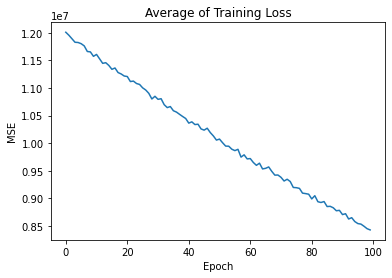

In [45]:
# training_loss的图
import matplotlib.pyplot as plt
plt.plot(trainloss_list)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Average of Training Loss")
plt.show()

In [48]:
pred = []
y = []
model.eval()
for (seq, target) in data_loader_test:
    seq = seq.to(device)
    target = target.to(device)
    y_pred = model(seq)
    pred.append(y_pred)
    y.append(target)
 
print(pred)

y=torch.cat(y, dim=0)
pred=torch.cat(pred, dim=0)
m, n = np.max(X_train), np.min(Y_train)
print(m,n)
y = (m - n) * y + n
pred = (m - n) * pred + n #torch.Size([179, 1])
print('MSE:', loss_function(y, pred))

[tensor([[668.9682],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683]], device='cuda:0', grad_fn=<SliceBackward0>), tensor([[668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683]], device='cuda:0', grad_fn=<SliceBackward0>), tensor([[668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [668.9683],
        [

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([250, 1])) that is different to the input size (torch.Size([250])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [47]:
pred

tensor([[4013140.2500],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.2500],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.2500],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140.5000],
        [4013140

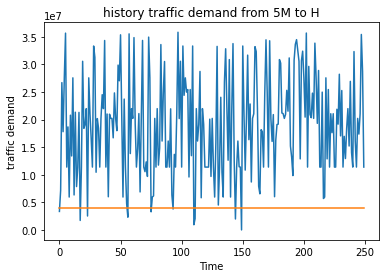

In [49]:
# plot
plt.plot(y.cpu().detach().numpy(), label='ground-truth')
plt.plot(pred.cpu().detach().numpy(), label='prediction')
plt.xlabel("Time")
plt.ylabel("traffic demand")
plt.title("history traffic demand from 5M to H")
plt.show()

In [ ]:

model = Sequential()
model.add(LSTM(400, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(400))
model.add(Dropout(0.2))
model.add(Dense(Y_modified.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.fit(X_modified, Y_modified, epochs=1, batch_size=256)

In [ ]:
def convert_to_char(sent):
      sent_str = ""
      for c in sent:
            sent_str += n_to_char[c]
      return sent_str

In [ ]:
print(convert_to_char(X[0]))
print(X[0])
print(convert_to_char(X[1]))
print(X[1])

In [ ]:
string_mapped = X[0]
full_string = [n_to_char[value] for value in string_mapped]
# generating characters
for i in range(1000):
    x = np.reshape(string_mapped,(1,len(string_mapped), 1))
    x = x / float(len(char))
    pred_index = np.argmax(model.predict(x, verbose=0))
    seq = convert_to_char(string_mapped)
    print(n_to_char[pred_index])
    full_string.append(n_to_char[pred_index])
    string_mapped.append(pred_index)
    string_mapped = string_mapped[1:len(string_mapped)]